# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='notebook_images/XY_season_images.png' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='notebook_images/horse2zebra.jpg' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite/` with a dash or an underscore, so take note, extract the data to your home directory and make sure the below `image_dir` matches. Then you can proceed with the following loading code.

In [1]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

import cnn_shape

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [2]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [3]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

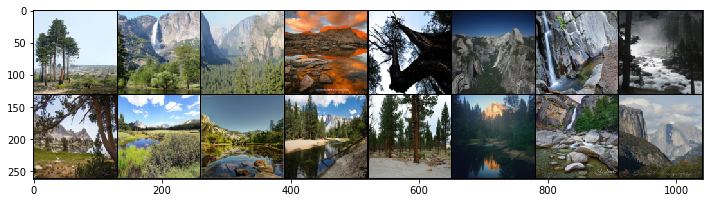

In [4]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

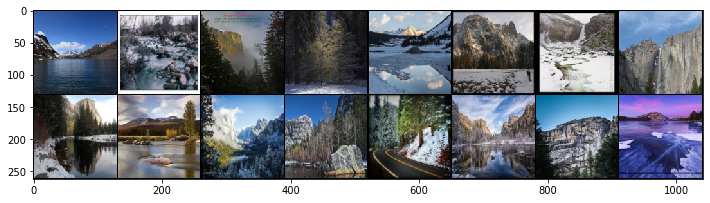

In [5]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

In [6]:
np.std(np.array([-1,1,1,-1]))

1.0

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0275)
Max:  tensor(0.9608)


In [8]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [9]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9451)
Scaled max:  tensor(0.9216)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='notebook_images/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super().__init__()

        self.layers = nn.ModuleList()
        
        self.__append_conv_block(3, conv_dim, with_batch_norm=False)
        self.__append_conv_block(conv_dim, conv_dim*2)
        self.__append_conv_block(conv_dim*2, conv_dim*4)
        self.__append_conv_block(conv_dim*4, conv_dim*8)
        
        self.layers.append(nn.Conv2d(conv_dim*8, 1, kernel_size=4, stride=1, padding=1))
        
    def __append_conv_block(self, input_depth: int, output_depth: int, with_batch_norm=True) -> None:
        assert self.layers is not None
        self.layers.append(nn.Conv2d(input_depth, output_depth, kernel_size=4, stride=2, padding=1, bias=(not with_batch_norm)))
        if with_batch_norm: 
            self.layers.append(nn.BatchNorm2d(output_depth))
        self.layers.append(nn.ReLU())
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [12]:
input_shape = torch.Size([16, 3, 128, 128])
cnn_shape.get_layer_output_shapes(input_shape, Discriminator())

{'layers': {'0': torch.Size([16, 64, 64, 64]),
  '1': torch.Size([16, 64, 64, 64]),
  '2': torch.Size([16, 128, 32, 32]),
  '3': torch.Size([16, 128, 32, 32]),
  '4': torch.Size([16, 128, 32, 32]),
  '5': torch.Size([16, 256, 16, 16]),
  '6': torch.Size([16, 256, 16, 16]),
  '7': torch.Size([16, 256, 16, 16]),
  '8': torch.Size([16, 512, 8, 8]),
  '9': torch.Size([16, 512, 8, 8]),
  '10': torch.Size([16, 512, 8, 8]),
  '11': torch.Size([16, 1, 7, 7])}}

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='notebook_images/resnet_50.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='notebook_images/resnet_block.png' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [13]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super().__init__()
        
        layers = nn.ModuleList()
        
        layers.append(nn.Conv2d(conv_dim, conv_dim, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(conv_dim))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(conv_dim, conv_dim, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(conv_dim))
        
        self.layers = layers
        
    def forward(self, x):  
        residual = x
        for layer in self.layers:
            residual = layer(residual)
        return (x + residual) / 2
    

In [14]:
input_shape = torch.Size([16, 3, 128, 128])
cnn_shape.get_layer_output_shapes(input_shape, ResidualBlock(3))

{'layers': {'0': torch.Size([16, 3, 128, 128]),
  '1': torch.Size([16, 3, 128, 128]),
  '2': torch.Size([16, 3, 128, 128]),
  '3': torch.Size([16, 3, 128, 128]),
  '4': torch.Size([16, 3, 128, 128])}}

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [15]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [16]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.__init_encoder(conv_dim)
        self.__init_residual_blocks(conv_dim*4, n_res_blocks)
        self.__init_decoder(conv_dim*4)
        
    def __init_encoder(self, first_conv_depth: int) -> None:
        assert self.layers is not None
        self.__append_conv_block(3, first_conv_depth)
        self.__append_conv_block(first_conv_depth, first_conv_depth*2)
        self.__append_conv_block(first_conv_depth*2, first_conv_depth*4)
        
    def __init_residual_blocks(self, depth: int, number_of_blocks: int) -> None:
        assert self.layers is not None
        for i in range(number_of_blocks):
            self.layers.append(ResidualBlock(depth))
            
    def __init_decoder(self, first_tconv_depth: int) -> None:
        assert self.layers is not None
        self.__append_transpose_block(first_tconv_depth, first_tconv_depth//2)
        self.__append_transpose_block(first_tconv_depth//2, first_tconv_depth//4)
        self.layers.append(nn.ConvTranspose2d(first_tconv_depth//4, 3, kernel_size=4, stride=2, padding=1))
        self.layers.append(nn.Tanh())
    
    def __append_conv_block(self, input_depth: int, output_depth: int, with_batch_norm=True) -> None:
        assert self.layers is not None
        self.layers.append(nn.Conv2d(input_depth, output_depth, kernel_size=4, stride=2, padding=1, bias=(not with_batch_norm)))
        if with_batch_norm: 
            self.layers.append(nn.BatchNorm2d(output_depth))
        self.layers.append(nn.ReLU())
        
    def __append_transpose_block(self, input_depth: int, output_depth: int, with_batch_norm=True) -> None:
        assert self.layers is not None
        self.layers.append(nn.ConvTranspose2d(input_depth, output_depth, kernel_size=4, stride=2, padding=1, bias=(not with_batch_norm)))
        if with_batch_norm: 
            self.layers.append(nn.BatchNorm2d(output_depth))
        self.layers.append(nn.ReLU())
        

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_dim)
        
    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        return torch.relu(self.norm(self.conv(input_tensor)))
    
    
class TransposeConvBlock(nn.Module):
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super().__init__()
        self.tconv = nn.ConvTranspose2d(in_dim, out_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_dim)
        
    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        return torch.relu(self.norm(self.tconv(input_tensor)))
    
    
class CombineBlock(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, use_tanh: bool=False) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_dim)
        self.activation = nn.Tanh() if use_tanh else nn.ReLU()
        
    def forward(self, input1: torch.Tensor, input2: torch.Tensor) -> torch.Tensor:
        combined_inputs = torch.cat((input1, input2), dim=1)
        return self.activation(self.norm(self.conv(combined_inputs)))

class ResidualGenerator(nn.Module):
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super().__init__()
        self.__init_encoder(conv_dim)
        self.__init_residual_blocks(conv_dim*4, n_res_blocks)
        self.__init_decoder(conv_dim*4)
        
        self.combine_block = CombineBlock(128, 64)
        
    def __init_encoder(self, first_conv_depth: int) -> None:
        self.conv1 = ConvBlock(3, first_conv_depth)
        self.conv2 = ConvBlock(first_conv_depth, first_conv_depth*2)
        self.conv3 = ConvBlock(first_conv_depth*2, first_conv_depth*4)
        
    def __init_decoder(self, first_tconv_depth: int) -> None:
        self.tconv1 = TransposeConvBlock(first_tconv_depth, first_tconv_depth//2)
        self.tconv2 = TransposeConvBlock(first_tconv_depth//2, first_tconv_depth//4)
        self.tconv3 = nn.ConvTranspose2d(first_tconv_depth//4, 3, kernel_size=4, stride=2, padding=1)
      
    def __init_residual_blocks(self, depth: int, number_of_blocks: int) -> None:
        self.residual_blocks = nn.ModuleList()
        for i in range(number_of_blocks):
            self.residual_blocks.append(ResidualBlock(depth))
        
    def forward(self, x):
        x = self.conv1(x)
        conv1_output = x
        x = self.conv2(x)
        x = self.conv3(x)
        
        for residual_block in self.residual_blocks:
            x = residual_block(x)
            
        x = self.tconv1(x)
        x = self.tconv2(x)
        x = self.combine_block(x, conv1_output)
        x = self.tconv3(x)
        x = torch.tanh(x)
        
        return x

In [18]:
class ResidualGeneratorMk2(ResidualGenerator):
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super().__init__(conv_dim, n_res_blocks)
        
        self.in_out_combine = CombineBlock(6, 3, use_tanh=True)
        
    def forward(self, x):
        network_input = x
        x = self.conv1(x)
        conv1_output = x
        x = self.conv2(x)
        x = self.conv3(x)
        
        for residual_block in self.residual_blocks:
            x = residual_block(x)
            
        x = self.tconv1(x)
        x = self.tconv2(x)
        x = self.combine_block(x, conv1_output)
        x = self.tconv3(x)
        x = torch.relu(x)
        x = self.in_out_combine(x, network_input)
        
        return x

In [19]:
class ResidualGeneratorMk3(ResidualGenerator):
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super().__init__(conv_dim, n_res_blocks)
        
        self.combine_block2 = CombineBlock(256, 128)
        self.in_out_combine = CombineBlock(6, 3, use_tanh=True)
        
    def forward(self, x):
        network_input = x
        x = self.conv1(x)
        conv1_output = x
        x = self.conv2(x)
        conv2_output = x
        x = self.conv3(x)
        
        for residual_block in self.residual_blocks:
            x = residual_block(x)
            
        x = self.tconv1(x)
        x = self.combine_block2(x, conv2_output)
        x = self.tconv2(x)
        x = self.combine_block(x, conv1_output)
        x = self.tconv3(x)
        x = torch.relu(x)
        x = self.in_out_combine(x, network_input)
        
        return x

In [20]:
class ResidualGeneratorMk4(ResidualGenerator):
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super().__init__(conv_dim, n_res_blocks)
        
        self.combine_block = CombineBlock(6, 3, use_tanh=True)
        
    def forward(self, x):
        network_input = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        for residual_block in self.residual_blocks:
            x = residual_block(x)
            
        x = self.tconv1(x)
        x = self.tconv2(x)
        x = self.tconv3(x)
        x = torch.relu(x)
        x = self.combine_block(x, network_input)
        
        return x

In [21]:
class StabilizerBlock(nn.Module):
    def __init__(self, dim: int) -> None:
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(dim)
        
    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        return torch.relu(self.norm(self.conv(input_tensor)))

class ResidualGeneratorMk5(nn.Module):
    def __init__(self, conv_dim=64, n_res_blocks=8):
        super().__init__()
        self.__init_encoder(conv_dim)
        self.__init_residual_blocks(conv_dim*4, n_res_blocks)
        self.__init_decoder(conv_dim*4)
        
        self.internal_combine_block = CombineBlock(128, 64)
        self.in_out_combine_block = CombineBlock(6, 3, use_tanh=True)
        
    def __init_encoder(self, first_conv_depth: int) -> None:
        self.conv1 = ConvBlock(3, first_conv_depth)
        self.conv11 = StabilizerBlock(first_conv_depth)
        self.conv2 = ConvBlock(first_conv_depth, first_conv_depth*2)
        self.conv22 = StabilizerBlock(first_conv_depth*2)
        self.conv3 = ConvBlock(first_conv_depth*2, first_conv_depth*4)
        self.conv33 = StabilizerBlock(first_conv_depth*4)
        
    def __init_decoder(self, first_tconv_depth: int) -> None:
        self.tconv1 = TransposeConvBlock(first_tconv_depth, first_tconv_depth//2)
        self.tconv11 = StabilizerBlock(first_tconv_depth//2)
        self.tconv2 = TransposeConvBlock(first_tconv_depth//2, first_tconv_depth//4)
        self.tconv22 = StabilizerBlock(first_tconv_depth//4)
        self.tconv3 = TransposeConvBlock(first_tconv_depth//4, 3)
        self.tconv33 = StabilizerBlock(3)
      
    def __init_residual_blocks(self, depth: int, number_of_blocks: int) -> None:
        self.residual_blocks = nn.ModuleList()
        for i in range(number_of_blocks):
            self.residual_blocks.append(ResidualBlock(depth))
        
    def forward(self, x):
        network_input = x
        x = self.conv1(x)
        x = self.conv11(x)
        conv11_output = x
        x = self.conv2(x)
        x = self.conv22(x)
        x = self.conv3(x)
        x = self.conv33(x)
        
        for residual_block in self.residual_blocks:
            x = residual_block(x)
            
        x = self.tconv1(x)
        x = self.tconv11(x)
        x = self.tconv2(x)
        x = self.tconv22(x)
        x = self.internal_combine_block(x, conv11_output)
        x = self.tconv3(x)
        x = self.tconv33(x)
        x = self.in_out_combine_block(x, network_input)
        
        return x

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [22]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = ResidualGeneratorMk2(g_conv_dim, n_res_blocks)
    G_YtoX = ResidualGeneratorMk2(g_conv_dim, n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(d_conv_dim)
    D_Y = Discriminator(d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [23]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [24]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
ResidualGeneratorMk2(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (residual_blocks): ModuleList(
    (0): ResidualBlock(
      (layers): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_ru

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='notebook_images/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='notebook_images/reconstruction_error.png' width=40% height=40% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.



In [25]:
t1 = torch.rand(100, 3, 128, 128)
t2 = torch.rand_like(t1)

def chunked_l1_loss(input: torch.Tensor, target: torch.Tensor, chunks_per_dim: int=4) -> float:
    l1_distances = F.l1_loss(input=input, target=target, reduction="none")
    x_chunks = torch.chunk(l1_distances, chunks=chunks_per_dim, dim=2)
    chunk_losses = []
    for x_chunk in x_chunks:
        for xy_chunk in torch.chunk(x_chunk, chunks=chunks_per_dim, dim=3):
            chunk_losses.append(torch.mean(xy_chunk))
    return max(chunk_losses)

In [26]:
def real_mse_loss(D_out):
    return F.mse_loss(input=D_out, target=torch.ones_like(D_out))
    

def fake_mse_loss(D_out):
    return F.mse_loss(input=D_out, target=torch.zeros_like(D_out))
    

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight=10):
    return lambda_weight * chunked_l1_loss(input=real_im, target=reconstructed_im)

### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


For all the experiments, we setλ= 10in Equation 3.We use the Adam solver [26] with a batch size of1.  Allnetworks were trained from scratch with a learning rate of0.0002.   We keep the same learning rate for the first100epochs and linearly decay the rate to zero over the next100epochs. Please see the appendix (Section 7) for more detailsabout the datasets, architectures, and training procedures.

In [27]:
import torch.optim as optim

# hyperparams for Adam optimizers
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='notebook_images/cycle_consistency_ex.png' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [28]:
# import save code
from helpers import save_samples, checkpoint

In [29]:
def discriminator_training_step(discriminator: Discriminator, 
                                real_images: torch.Tensor, 
                                fake_images: torch.Tensor, 
                                optimizer: torch.optim.Optimizer) -> torch.Tensor:

    real_output = discriminator(real_images)
    real_loss = real_mse_loss(real_output)
    
    fake_output = discriminator(fake_images)
    fake_loss = fake_mse_loss(fake_output)
    
    total_loss = real_loss + fake_loss
    total_loss.backward()
    optimizer.step()
    
    return total_loss

In [30]:
def calculate_generator_losses(primary_generator: CycleGenerator,
                               reconstruction_generator: CycleGenerator,
                               discriminator: Discriminator,
                               images: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    
    fake_images = primary_generator(images)
    disc_output = discriminator(fake_images)
    primary_loss = real_mse_loss(disc_output)
    
    reconstructed_images = reconstruction_generator(fake_images)
    reconstruction_loss = cycle_consistency_loss(images, reconstructed_images)
    
    return primary_loss, reconstruction_loss

In [31]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))
    
    G_XtoY.train()
    G_YtoX.train()
    D_X.train() 
    D_Y.train()

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)

        g_optimizer.zero_grad()
        d_x_optimizer.zero_grad()
        d_y_optimizer.zero_grad()

        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        d_x_loss = discriminator_training_step(D_X, images_X, G_YtoX(images_Y), d_x_optimizer)
        d_y_loss = discriminator_training_step(D_Y, images_Y, G_XtoY(images_X), d_y_optimizer)

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================
        
        g_x_loss, y_recon_loss = calculate_generator_losses(G_YtoX, G_XtoY, D_X, images_Y)
        g_y_loss, x_recon_loss = calculate_generator_losses(G_XtoY, G_YtoX, D_Y, images_X)

        g_total_loss = g_x_loss + g_y_loss + y_recon_loss + x_recon_loss
        g_total_loss.backward()
        g_optimizer.step()

        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [32]:
n_epochs = 4000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 4000] | d_X_loss: 0.2578 | d_Y_loss: 0.3499 | g_total_loss: 9.6064
Epoch [   20/ 4000] | d_X_loss: 0.1492 | d_Y_loss: 0.2949 | g_total_loss: 9.7236
Epoch [   30/ 4000] | d_X_loss: 0.1578 | d_Y_loss: 0.1835 | g_total_loss: 7.7056
Epoch [   40/ 4000] | d_X_loss: 0.1106 | d_Y_loss: 0.3890 | g_total_loss: 6.1598
Epoch [   50/ 4000] | d_X_loss: 0.2465 | d_Y_loss: 0.6810 | g_total_loss: 7.1325
Epoch [   60/ 4000] | d_X_loss: 0.0909 | d_Y_loss: 0.7502 | g_total_loss: 5.1763
Epoch [   70/ 4000] | d_X_loss: 0.2499 | d_Y_loss: 0.2374 | g_total_loss: 5.3193
Epoch [   80/ 4000] | d_X_loss: 0.0777 | d_Y_loss: 0.1857 | g_total_loss: 5.9638
Epoch [   90/ 4000] | d_X_loss: 0.1073 | d_Y_loss: 0.2546 | g_total_loss: 4.2217


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  100/ 4000] | d_X_loss: 0.0553 | d_Y_loss: 0.3055 | g_total_loss: 7.1652


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000100-X-Y.png
Saved samples_cyclegan\sample-000100-Y-X.png
Epoch [  110/ 4000] | d_X_loss: 0.0716 | d_Y_loss: 0.2465 | g_total_loss: 5.3755
Epoch [  120/ 4000] | d_X_loss: 0.9371 | d_Y_loss: 0.2773 | g_total_loss: 4.4541
Epoch [  130/ 4000] | d_X_loss: 0.0727 | d_Y_loss: 0.0744 | g_total_loss: 5.5121
Epoch [  140/ 4000] | d_X_loss: 0.1338 | d_Y_loss: 0.1398 | g_total_loss: 5.2317
Epoch [  150/ 4000] | d_X_loss: 0.0988 | d_Y_loss: 1.0496 | g_total_loss: 5.3600
Epoch [  160/ 4000] | d_X_loss: 0.0628 | d_Y_loss: 0.1233 | g_total_loss: 5.6203
Epoch [  170/ 4000] | d_X_loss: 0.0589 | d_Y_loss: 0.0530 | g_total_loss: 5.5046
Epoch [  180/ 4000] | d_X_loss: 1.0917 | d_Y_loss: 0.1491 | g_total_loss: 4.3851
Epoch [  190/ 4000] | d_X_loss: 0.0931 | d_Y_loss: 0.1620 | g_total_loss: 5.0389


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  200/ 4000] | d_X_loss: 0.0886 | d_Y_loss: 0.5323 | g_total_loss: 5.0983


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000200-X-Y.png
Saved samples_cyclegan\sample-000200-Y-X.png
Epoch [  210/ 4000] | d_X_loss: 0.9384 | d_Y_loss: 0.3399 | g_total_loss: 3.4724
Epoch [  220/ 4000] | d_X_loss: 0.2686 | d_Y_loss: 0.1501 | g_total_loss: 5.5108
Epoch [  230/ 4000] | d_X_loss: 0.0267 | d_Y_loss: 0.2854 | g_total_loss: 5.0606
Epoch [  240/ 4000] | d_X_loss: 0.1985 | d_Y_loss: 0.4523 | g_total_loss: 3.5354
Epoch [  250/ 4000] | d_X_loss: 0.2117 | d_Y_loss: 0.5741 | g_total_loss: 4.5348
Epoch [  260/ 4000] | d_X_loss: 0.1417 | d_Y_loss: 0.1706 | g_total_loss: 3.7001
Epoch [  270/ 4000] | d_X_loss: 0.0689 | d_Y_loss: 0.4001 | g_total_loss: 3.9365
Epoch [  280/ 4000] | d_X_loss: 0.0465 | d_Y_loss: 0.2691 | g_total_loss: 4.7283
Epoch [  290/ 4000] | d_X_loss: 0.5610 | d_Y_loss: 0.1412 | g_total_loss: 5.4572


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  300/ 4000] | d_X_loss: 0.1187 | d_Y_loss: 0.2483 | g_total_loss: 4.1959


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000300-X-Y.png
Saved samples_cyclegan\sample-000300-Y-X.png
Epoch [  310/ 4000] | d_X_loss: 0.2884 | d_Y_loss: 0.3064 | g_total_loss: 3.1845
Epoch [  320/ 4000] | d_X_loss: 0.0749 | d_Y_loss: 0.6430 | g_total_loss: 3.5393
Epoch [  330/ 4000] | d_X_loss: 0.0422 | d_Y_loss: 0.2032 | g_total_loss: 5.2960
Epoch [  340/ 4000] | d_X_loss: 0.1956 | d_Y_loss: 0.2777 | g_total_loss: 4.0372
Epoch [  350/ 4000] | d_X_loss: 0.1283 | d_Y_loss: 0.0626 | g_total_loss: 4.8171
Epoch [  360/ 4000] | d_X_loss: 0.0596 | d_Y_loss: 0.2294 | g_total_loss: 4.0959
Epoch [  370/ 4000] | d_X_loss: 0.2538 | d_Y_loss: 0.3939 | g_total_loss: 2.9936
Epoch [  380/ 4000] | d_X_loss: 0.6345 | d_Y_loss: 0.3259 | g_total_loss: 3.5895
Epoch [  390/ 4000] | d_X_loss: 0.1713 | d_Y_loss: 0.5491 | g_total_loss: 3.5832


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  400/ 4000] | d_X_loss: 0.4347 | d_Y_loss: 0.2126 | g_total_loss: 3.2966


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000400-X-Y.png
Saved samples_cyclegan\sample-000400-Y-X.png
Epoch [  410/ 4000] | d_X_loss: 0.1911 | d_Y_loss: 0.0500 | g_total_loss: 4.7137
Epoch [  420/ 4000] | d_X_loss: 0.3420 | d_Y_loss: 0.3078 | g_total_loss: 3.3340
Epoch [  430/ 4000] | d_X_loss: 0.2253 | d_Y_loss: 0.1867 | g_total_loss: 4.1146
Epoch [  440/ 4000] | d_X_loss: 0.1403 | d_Y_loss: 0.2298 | g_total_loss: 4.0029
Epoch [  450/ 4000] | d_X_loss: 0.1639 | d_Y_loss: 0.1257 | g_total_loss: 5.0074
Epoch [  460/ 4000] | d_X_loss: 0.2895 | d_Y_loss: 0.2011 | g_total_loss: 4.6365
Epoch [  470/ 4000] | d_X_loss: 0.1477 | d_Y_loss: 0.2346 | g_total_loss: 4.7839
Epoch [  480/ 4000] | d_X_loss: 0.1452 | d_Y_loss: 0.1636 | g_total_loss: 4.3696
Epoch [  490/ 4000] | d_X_loss: 0.2905 | d_Y_loss: 0.4745 | g_total_loss: 4.2336


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  500/ 4000] | d_X_loss: 0.1715 | d_Y_loss: 0.1753 | g_total_loss: 4.0113


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000500-X-Y.png
Saved samples_cyclegan\sample-000500-Y-X.png
Epoch [  510/ 4000] | d_X_loss: 0.0475 | d_Y_loss: 0.1941 | g_total_loss: 3.3585
Epoch [  520/ 4000] | d_X_loss: 0.5311 | d_Y_loss: 0.2297 | g_total_loss: 3.0119
Epoch [  530/ 4000] | d_X_loss: 0.3712 | d_Y_loss: 0.5113 | g_total_loss: 2.6152
Epoch [  540/ 4000] | d_X_loss: 0.0747 | d_Y_loss: 0.0836 | g_total_loss: 3.8302
Epoch [  550/ 4000] | d_X_loss: 0.1639 | d_Y_loss: 0.1713 | g_total_loss: 4.2511
Epoch [  560/ 4000] | d_X_loss: 0.7050 | d_Y_loss: 0.6328 | g_total_loss: 4.5097
Epoch [  570/ 4000] | d_X_loss: 0.0395 | d_Y_loss: 0.3867 | g_total_loss: 4.1276
Epoch [  580/ 4000] | d_X_loss: 0.1592 | d_Y_loss: 0.3564 | g_total_loss: 4.4159
Epoch [  590/ 4000] | d_X_loss: 0.2621 | d_Y_loss: 0.4232 | g_total_loss: 2.9147


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  600/ 4000] | d_X_loss: 0.0863 | d_Y_loss: 0.1443 | g_total_loss: 3.7227


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000600-X-Y.png
Saved samples_cyclegan\sample-000600-Y-X.png
Epoch [  610/ 4000] | d_X_loss: 0.0502 | d_Y_loss: 0.2586 | g_total_loss: 4.1761
Epoch [  620/ 4000] | d_X_loss: 0.2330 | d_Y_loss: 0.3655 | g_total_loss: 3.0178
Epoch [  630/ 4000] | d_X_loss: 0.2960 | d_Y_loss: 0.4988 | g_total_loss: 2.9408
Epoch [  640/ 4000] | d_X_loss: 0.1883 | d_Y_loss: 0.0855 | g_total_loss: 3.5945
Epoch [  650/ 4000] | d_X_loss: 0.2038 | d_Y_loss: 0.2504 | g_total_loss: 3.0886
Epoch [  660/ 4000] | d_X_loss: 0.1063 | d_Y_loss: 0.1486 | g_total_loss: 3.8637
Epoch [  670/ 4000] | d_X_loss: 0.2927 | d_Y_loss: 0.1175 | g_total_loss: 4.8616
Epoch [  680/ 4000] | d_X_loss: 0.1161 | d_Y_loss: 0.3541 | g_total_loss: 3.2966
Epoch [  690/ 4000] | d_X_loss: 0.2693 | d_Y_loss: 0.3246 | g_total_loss: 3.6205


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  700/ 4000] | d_X_loss: 0.1062 | d_Y_loss: 0.2454 | g_total_loss: 3.6281


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000700-X-Y.png
Saved samples_cyclegan\sample-000700-Y-X.png
Epoch [  710/ 4000] | d_X_loss: 0.3640 | d_Y_loss: 0.1398 | g_total_loss: 3.1375
Epoch [  720/ 4000] | d_X_loss: 0.3667 | d_Y_loss: 0.1847 | g_total_loss: 3.0452
Epoch [  730/ 4000] | d_X_loss: 0.1442 | d_Y_loss: 0.2287 | g_total_loss: 3.8275
Epoch [  740/ 4000] | d_X_loss: 0.4640 | d_Y_loss: 0.2959 | g_total_loss: 2.4614
Epoch [  750/ 4000] | d_X_loss: 0.2170 | d_Y_loss: 0.9260 | g_total_loss: 3.3286
Epoch [  760/ 4000] | d_X_loss: 0.2199 | d_Y_loss: 0.2270 | g_total_loss: 3.1707
Epoch [  770/ 4000] | d_X_loss: 0.1770 | d_Y_loss: 0.4930 | g_total_loss: 3.5309
Epoch [  780/ 4000] | d_X_loss: 0.3419 | d_Y_loss: 0.1209 | g_total_loss: 4.0331
Epoch [  790/ 4000] | d_X_loss: 0.2865 | d_Y_loss: 0.4388 | g_total_loss: 2.2902


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  800/ 4000] | d_X_loss: 0.5148 | d_Y_loss: 0.2344 | g_total_loss: 2.6596


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000800-X-Y.png
Saved samples_cyclegan\sample-000800-Y-X.png
Epoch [  810/ 4000] | d_X_loss: 0.2268 | d_Y_loss: 0.4128 | g_total_loss: 3.1730
Epoch [  820/ 4000] | d_X_loss: 0.3117 | d_Y_loss: 0.1908 | g_total_loss: 2.8237
Epoch [  830/ 4000] | d_X_loss: 0.1972 | d_Y_loss: 0.2408 | g_total_loss: 3.0960
Epoch [  840/ 4000] | d_X_loss: 0.3694 | d_Y_loss: 0.2678 | g_total_loss: 2.5793
Epoch [  850/ 4000] | d_X_loss: 0.1893 | d_Y_loss: 0.2362 | g_total_loss: 4.0768
Epoch [  860/ 4000] | d_X_loss: 0.2633 | d_Y_loss: 0.2732 | g_total_loss: 3.3366
Epoch [  870/ 4000] | d_X_loss: 0.5074 | d_Y_loss: 0.1910 | g_total_loss: 2.8542
Epoch [  880/ 4000] | d_X_loss: 0.9316 | d_Y_loss: 0.1246 | g_total_loss: 3.9137
Epoch [  890/ 4000] | d_X_loss: 0.2388 | d_Y_loss: 0.1491 | g_total_loss: 3.4883


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [  900/ 4000] | d_X_loss: 0.2361 | d_Y_loss: 0.4317 | g_total_loss: 2.8203


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000900-X-Y.png
Saved samples_cyclegan\sample-000900-Y-X.png
Epoch [  910/ 4000] | d_X_loss: 0.3833 | d_Y_loss: 0.2771 | g_total_loss: 4.1343
Epoch [  920/ 4000] | d_X_loss: 0.4466 | d_Y_loss: 0.2054 | g_total_loss: 3.7202
Epoch [  930/ 4000] | d_X_loss: 0.1339 | d_Y_loss: 0.1790 | g_total_loss: 3.5441
Epoch [  940/ 4000] | d_X_loss: 0.4176 | d_Y_loss: 0.3199 | g_total_loss: 3.3634
Epoch [  950/ 4000] | d_X_loss: 0.4401 | d_Y_loss: 0.5713 | g_total_loss: 2.9545
Epoch [  960/ 4000] | d_X_loss: 0.2231 | d_Y_loss: 0.4415 | g_total_loss: 3.7694
Epoch [  970/ 4000] | d_X_loss: 0.1928 | d_Y_loss: 0.0848 | g_total_loss: 3.6612
Epoch [  980/ 4000] | d_X_loss: 0.1806 | d_Y_loss: 0.2718 | g_total_loss: 3.6682
Epoch [  990/ 4000] | d_X_loss: 0.1561 | d_Y_loss: 0.1239 | g_total_loss: 2.9464


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1000/ 4000] | d_X_loss: 0.1329 | d_Y_loss: 0.2642 | g_total_loss: 3.1826


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001000-X-Y.png
Saved samples_cyclegan\sample-001000-Y-X.png
Epoch [ 1010/ 4000] | d_X_loss: 0.2047 | d_Y_loss: 0.0563 | g_total_loss: 4.0829
Epoch [ 1020/ 4000] | d_X_loss: 0.2618 | d_Y_loss: 0.4900 | g_total_loss: 3.3026
Epoch [ 1030/ 4000] | d_X_loss: 0.1054 | d_Y_loss: 0.2231 | g_total_loss: 2.8836
Epoch [ 1040/ 4000] | d_X_loss: 0.0760 | d_Y_loss: 0.1732 | g_total_loss: 3.6418
Epoch [ 1050/ 4000] | d_X_loss: 0.2447 | d_Y_loss: 0.4113 | g_total_loss: 3.2038
Epoch [ 1060/ 4000] | d_X_loss: 0.1355 | d_Y_loss: 0.3577 | g_total_loss: 3.5209
Epoch [ 1070/ 4000] | d_X_loss: 0.0685 | d_Y_loss: 0.1248 | g_total_loss: 4.2076
Epoch [ 1080/ 4000] | d_X_loss: 0.0858 | d_Y_loss: 0.2924 | g_total_loss: 2.6372
Epoch [ 1090/ 4000] | d_X_loss: 0.1366 | d_Y_loss: 0.3776 | g_total_loss: 3.3162


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1100/ 4000] | d_X_loss: 0.1288 | d_Y_loss: 0.0526 | g_total_loss: 3.3780


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001100-X-Y.png
Saved samples_cyclegan\sample-001100-Y-X.png
Epoch [ 1110/ 4000] | d_X_loss: 0.1519 | d_Y_loss: 0.2385 | g_total_loss: 3.1167
Epoch [ 1120/ 4000] | d_X_loss: 0.5759 | d_Y_loss: 0.2298 | g_total_loss: 3.5464
Epoch [ 1130/ 4000] | d_X_loss: 0.1610 | d_Y_loss: 0.1473 | g_total_loss: 2.7930
Epoch [ 1140/ 4000] | d_X_loss: 0.2300 | d_Y_loss: 0.3380 | g_total_loss: 3.4803
Epoch [ 1150/ 4000] | d_X_loss: 0.2919 | d_Y_loss: 0.3488 | g_total_loss: 2.6396
Epoch [ 1160/ 4000] | d_X_loss: 0.3203 | d_Y_loss: 0.5123 | g_total_loss: 2.5698
Epoch [ 1170/ 4000] | d_X_loss: 0.1906 | d_Y_loss: 0.1965 | g_total_loss: 3.0125
Epoch [ 1180/ 4000] | d_X_loss: 0.1238 | d_Y_loss: 0.1160 | g_total_loss: 4.3130
Epoch [ 1190/ 4000] | d_X_loss: 0.3501 | d_Y_loss: 0.1499 | g_total_loss: 3.7027


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1200/ 4000] | d_X_loss: 0.1084 | d_Y_loss: 0.1350 | g_total_loss: 3.7282


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001200-X-Y.png
Saved samples_cyclegan\sample-001200-Y-X.png
Epoch [ 1210/ 4000] | d_X_loss: 0.5362 | d_Y_loss: 0.2365 | g_total_loss: 2.7148
Epoch [ 1220/ 4000] | d_X_loss: 0.7571 | d_Y_loss: 0.2380 | g_total_loss: 3.3535
Epoch [ 1230/ 4000] | d_X_loss: 0.2195 | d_Y_loss: 0.5009 | g_total_loss: 3.0892
Epoch [ 1240/ 4000] | d_X_loss: 0.4302 | d_Y_loss: 0.3989 | g_total_loss: 2.8838
Epoch [ 1250/ 4000] | d_X_loss: 0.3773 | d_Y_loss: 0.1163 | g_total_loss: 3.5026
Epoch [ 1260/ 4000] | d_X_loss: 0.1860 | d_Y_loss: 0.2172 | g_total_loss: 2.7553
Epoch [ 1270/ 4000] | d_X_loss: 0.4156 | d_Y_loss: 0.4595 | g_total_loss: 2.2851
Epoch [ 1280/ 4000] | d_X_loss: 0.4541 | d_Y_loss: 0.3428 | g_total_loss: 4.0405
Epoch [ 1290/ 4000] | d_X_loss: 0.4351 | d_Y_loss: 0.2666 | g_total_loss: 2.7984


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1300/ 4000] | d_X_loss: 0.2474 | d_Y_loss: 0.5823 | g_total_loss: 4.3263


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001300-X-Y.png
Saved samples_cyclegan\sample-001300-Y-X.png
Epoch [ 1310/ 4000] | d_X_loss: 0.3477 | d_Y_loss: 0.4966 | g_total_loss: 4.3892
Epoch [ 1320/ 4000] | d_X_loss: 0.3619 | d_Y_loss: 0.5517 | g_total_loss: 4.0499
Epoch [ 1330/ 4000] | d_X_loss: 0.4703 | d_Y_loss: 0.1033 | g_total_loss: 3.1233
Epoch [ 1340/ 4000] | d_X_loss: 0.2247 | d_Y_loss: 0.2984 | g_total_loss: 3.4235
Epoch [ 1350/ 4000] | d_X_loss: 0.1787 | d_Y_loss: 0.1700 | g_total_loss: 2.8093
Epoch [ 1360/ 4000] | d_X_loss: 0.2407 | d_Y_loss: 0.0515 | g_total_loss: 3.8356
Epoch [ 1370/ 4000] | d_X_loss: 0.2731 | d_Y_loss: 0.2247 | g_total_loss: 3.0371
Epoch [ 1380/ 4000] | d_X_loss: 0.5644 | d_Y_loss: 0.5929 | g_total_loss: 3.7901
Epoch [ 1390/ 4000] | d_X_loss: 0.2169 | d_Y_loss: 0.2068 | g_total_loss: 2.4864


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1400/ 4000] | d_X_loss: 0.1959 | d_Y_loss: 0.1459 | g_total_loss: 4.5122


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001400-X-Y.png
Saved samples_cyclegan\sample-001400-Y-X.png
Epoch [ 1410/ 4000] | d_X_loss: 0.5173 | d_Y_loss: 0.2474 | g_total_loss: 3.2348
Epoch [ 1420/ 4000] | d_X_loss: 0.4016 | d_Y_loss: 0.2957 | g_total_loss: 3.9293
Epoch [ 1430/ 4000] | d_X_loss: 0.2354 | d_Y_loss: 0.1834 | g_total_loss: 2.6462
Epoch [ 1440/ 4000] | d_X_loss: 0.1434 | d_Y_loss: 0.0932 | g_total_loss: 3.0707
Epoch [ 1450/ 4000] | d_X_loss: 0.4993 | d_Y_loss: 0.1662 | g_total_loss: 2.7406
Epoch [ 1460/ 4000] | d_X_loss: 0.2886 | d_Y_loss: 0.9173 | g_total_loss: 2.9956
Epoch [ 1470/ 4000] | d_X_loss: 0.5178 | d_Y_loss: 0.2146 | g_total_loss: 2.6517
Epoch [ 1480/ 4000] | d_X_loss: 0.1797 | d_Y_loss: 0.3594 | g_total_loss: 2.4632
Epoch [ 1490/ 4000] | d_X_loss: 0.3372 | d_Y_loss: 0.2139 | g_total_loss: 3.4495


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1500/ 4000] | d_X_loss: 0.1810 | d_Y_loss: 0.2317 | g_total_loss: 3.6370


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001500-X-Y.png
Saved samples_cyclegan\sample-001500-Y-X.png
Epoch [ 1510/ 4000] | d_X_loss: 0.1865 | d_Y_loss: 0.4375 | g_total_loss: 3.1186
Epoch [ 1520/ 4000] | d_X_loss: 0.2722 | d_Y_loss: 0.2380 | g_total_loss: 2.6611
Epoch [ 1530/ 4000] | d_X_loss: 0.1775 | d_Y_loss: 0.1268 | g_total_loss: 2.9331
Epoch [ 1540/ 4000] | d_X_loss: 0.3072 | d_Y_loss: 0.2487 | g_total_loss: 3.2548
Epoch [ 1550/ 4000] | d_X_loss: 0.2946 | d_Y_loss: 0.4176 | g_total_loss: 3.0726
Epoch [ 1560/ 4000] | d_X_loss: 0.1819 | d_Y_loss: 0.3097 | g_total_loss: 2.8747
Epoch [ 1570/ 4000] | d_X_loss: 0.3129 | d_Y_loss: 0.3470 | g_total_loss: 2.6628
Epoch [ 1580/ 4000] | d_X_loss: 0.1868 | d_Y_loss: 0.3753 | g_total_loss: 2.9011
Epoch [ 1590/ 4000] | d_X_loss: 0.3965 | d_Y_loss: 0.3613 | g_total_loss: 3.1171


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1600/ 4000] | d_X_loss: 0.1360 | d_Y_loss: 0.2275 | g_total_loss: 3.3382


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001600-X-Y.png
Saved samples_cyclegan\sample-001600-Y-X.png
Epoch [ 1610/ 4000] | d_X_loss: 0.2473 | d_Y_loss: 0.1935 | g_total_loss: 2.7700
Epoch [ 1620/ 4000] | d_X_loss: 0.6364 | d_Y_loss: 0.6212 | g_total_loss: 4.1156
Epoch [ 1630/ 4000] | d_X_loss: 0.1001 | d_Y_loss: 0.2542 | g_total_loss: 3.2838
Epoch [ 1640/ 4000] | d_X_loss: 0.1739 | d_Y_loss: 0.0848 | g_total_loss: 4.3419
Epoch [ 1650/ 4000] | d_X_loss: 0.2211 | d_Y_loss: 0.2307 | g_total_loss: 3.1538
Epoch [ 1660/ 4000] | d_X_loss: 0.2104 | d_Y_loss: 0.1439 | g_total_loss: 3.4856
Epoch [ 1670/ 4000] | d_X_loss: 0.0415 | d_Y_loss: 0.1083 | g_total_loss: 3.5090
Epoch [ 1680/ 4000] | d_X_loss: 0.0815 | d_Y_loss: 0.5555 | g_total_loss: 3.3324
Epoch [ 1690/ 4000] | d_X_loss: 0.2045 | d_Y_loss: 0.2656 | g_total_loss: 3.8620


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1700/ 4000] | d_X_loss: 0.3661 | d_Y_loss: 0.3592 | g_total_loss: 2.4182


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001700-X-Y.png
Saved samples_cyclegan\sample-001700-Y-X.png
Epoch [ 1710/ 4000] | d_X_loss: 0.1226 | d_Y_loss: 0.3155 | g_total_loss: 2.8187
Epoch [ 1720/ 4000] | d_X_loss: 0.3444 | d_Y_loss: 0.3953 | g_total_loss: 3.5072
Epoch [ 1730/ 4000] | d_X_loss: 0.0660 | d_Y_loss: 0.2997 | g_total_loss: 3.8530
Epoch [ 1740/ 4000] | d_X_loss: 0.1892 | d_Y_loss: 0.1909 | g_total_loss: 3.6166
Epoch [ 1750/ 4000] | d_X_loss: 0.2530 | d_Y_loss: 0.1102 | g_total_loss: 2.9679
Epoch [ 1760/ 4000] | d_X_loss: 0.2084 | d_Y_loss: 0.1640 | g_total_loss: 2.8027
Epoch [ 1770/ 4000] | d_X_loss: 0.1335 | d_Y_loss: 0.1582 | g_total_loss: 3.9215
Epoch [ 1780/ 4000] | d_X_loss: 0.0776 | d_Y_loss: 0.1086 | g_total_loss: 4.8846
Epoch [ 1790/ 4000] | d_X_loss: 0.1450 | d_Y_loss: 0.6397 | g_total_loss: 3.4132


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1800/ 4000] | d_X_loss: 0.7018 | d_Y_loss: 0.2766 | g_total_loss: 2.6728


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001800-X-Y.png
Saved samples_cyclegan\sample-001800-Y-X.png
Epoch [ 1810/ 4000] | d_X_loss: 0.6306 | d_Y_loss: 0.2881 | g_total_loss: 2.8548
Epoch [ 1820/ 4000] | d_X_loss: 0.4334 | d_Y_loss: 0.2763 | g_total_loss: 2.7118
Epoch [ 1830/ 4000] | d_X_loss: 0.3351 | d_Y_loss: 0.1271 | g_total_loss: 3.3148
Epoch [ 1840/ 4000] | d_X_loss: 0.3792 | d_Y_loss: 0.1594 | g_total_loss: 3.2223
Epoch [ 1850/ 4000] | d_X_loss: 0.1898 | d_Y_loss: 0.2858 | g_total_loss: 2.8494
Epoch [ 1860/ 4000] | d_X_loss: 0.2717 | d_Y_loss: 0.4984 | g_total_loss: 3.1452
Epoch [ 1870/ 4000] | d_X_loss: 0.3294 | d_Y_loss: 0.2025 | g_total_loss: 3.0011
Epoch [ 1880/ 4000] | d_X_loss: 0.2505 | d_Y_loss: 0.2008 | g_total_loss: 3.2790
Epoch [ 1890/ 4000] | d_X_loss: 0.2918 | d_Y_loss: 1.5329 | g_total_loss: 3.3110


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 1900/ 4000] | d_X_loss: 0.3213 | d_Y_loss: 0.5358 | g_total_loss: 2.4009


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001900-X-Y.png
Saved samples_cyclegan\sample-001900-Y-X.png
Epoch [ 1910/ 4000] | d_X_loss: 0.2755 | d_Y_loss: 0.3145 | g_total_loss: 3.0700
Epoch [ 1920/ 4000] | d_X_loss: 0.0587 | d_Y_loss: 0.1933 | g_total_loss: 3.9961
Epoch [ 1930/ 4000] | d_X_loss: 0.1754 | d_Y_loss: 0.4002 | g_total_loss: 3.5382
Epoch [ 1940/ 4000] | d_X_loss: 0.2530 | d_Y_loss: 0.1036 | g_total_loss: 3.2525
Epoch [ 1950/ 4000] | d_X_loss: 0.2734 | d_Y_loss: 0.3359 | g_total_loss: 3.2919
Epoch [ 1960/ 4000] | d_X_loss: 0.2735 | d_Y_loss: 0.3077 | g_total_loss: 2.3659
Epoch [ 1970/ 4000] | d_X_loss: 0.2790 | d_Y_loss: 0.3642 | g_total_loss: 3.0800
Epoch [ 1980/ 4000] | d_X_loss: 0.1669 | d_Y_loss: 0.2147 | g_total_loss: 2.7290
Epoch [ 1990/ 4000] | d_X_loss: 0.2693 | d_Y_loss: 0.3179 | g_total_loss: 2.6856


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2000/ 4000] | d_X_loss: 0.2282 | d_Y_loss: 0.1932 | g_total_loss: 3.3190


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002000-X-Y.png
Saved samples_cyclegan\sample-002000-Y-X.png
Epoch [ 2010/ 4000] | d_X_loss: 0.3887 | d_Y_loss: 0.6839 | g_total_loss: 2.3096
Epoch [ 2020/ 4000] | d_X_loss: 0.0843 | d_Y_loss: 0.2102 | g_total_loss: 3.4382
Epoch [ 2030/ 4000] | d_X_loss: 0.2664 | d_Y_loss: 0.2716 | g_total_loss: 3.3040
Epoch [ 2040/ 4000] | d_X_loss: 0.1853 | d_Y_loss: 0.0679 | g_total_loss: 3.4731
Epoch [ 2050/ 4000] | d_X_loss: 0.3083 | d_Y_loss: 0.1246 | g_total_loss: 3.1979
Epoch [ 2060/ 4000] | d_X_loss: 0.5098 | d_Y_loss: 0.4090 | g_total_loss: 2.7348
Epoch [ 2070/ 4000] | d_X_loss: 0.4204 | d_Y_loss: 1.0044 | g_total_loss: 3.6963
Epoch [ 2080/ 4000] | d_X_loss: 0.9215 | d_Y_loss: 0.3323 | g_total_loss: 2.2790
Epoch [ 2090/ 4000] | d_X_loss: 0.3848 | d_Y_loss: 0.1927 | g_total_loss: 3.5645


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2100/ 4000] | d_X_loss: 0.2739 | d_Y_loss: 0.1888 | g_total_loss: 3.2124


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002100-X-Y.png
Saved samples_cyclegan\sample-002100-Y-X.png
Epoch [ 2110/ 4000] | d_X_loss: 0.2528 | d_Y_loss: 0.2331 | g_total_loss: 4.0411
Epoch [ 2120/ 4000] | d_X_loss: 0.3036 | d_Y_loss: 0.1851 | g_total_loss: 3.5567
Epoch [ 2130/ 4000] | d_X_loss: 0.3483 | d_Y_loss: 0.6120 | g_total_loss: 2.6177
Epoch [ 2140/ 4000] | d_X_loss: 0.2385 | d_Y_loss: 0.1881 | g_total_loss: 3.0375
Epoch [ 2150/ 4000] | d_X_loss: 0.2485 | d_Y_loss: 0.1584 | g_total_loss: 3.0189
Epoch [ 2160/ 4000] | d_X_loss: 0.1940 | d_Y_loss: 0.1892 | g_total_loss: 3.1309
Epoch [ 2170/ 4000] | d_X_loss: 0.5882 | d_Y_loss: 0.4282 | g_total_loss: 2.4540
Epoch [ 2180/ 4000] | d_X_loss: 0.2114 | d_Y_loss: 0.1604 | g_total_loss: 3.3279
Epoch [ 2190/ 4000] | d_X_loss: 0.3971 | d_Y_loss: 0.1452 | g_total_loss: 3.7924


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2200/ 4000] | d_X_loss: 0.0862 | d_Y_loss: 0.2308 | g_total_loss: 3.1121


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002200-X-Y.png
Saved samples_cyclegan\sample-002200-Y-X.png
Epoch [ 2210/ 4000] | d_X_loss: 0.1272 | d_Y_loss: 0.0898 | g_total_loss: 3.5300
Epoch [ 2220/ 4000] | d_X_loss: 0.3153 | d_Y_loss: 0.3779 | g_total_loss: 3.2824
Epoch [ 2230/ 4000] | d_X_loss: 0.2927 | d_Y_loss: 0.2393 | g_total_loss: 3.4933
Epoch [ 2240/ 4000] | d_X_loss: 0.2402 | d_Y_loss: 0.2627 | g_total_loss: 3.3733
Epoch [ 2250/ 4000] | d_X_loss: 0.1749 | d_Y_loss: 0.4154 | g_total_loss: 2.9269
Epoch [ 2260/ 4000] | d_X_loss: 0.1532 | d_Y_loss: 0.3007 | g_total_loss: 3.8090
Epoch [ 2270/ 4000] | d_X_loss: 0.1907 | d_Y_loss: 0.1614 | g_total_loss: 3.7969
Epoch [ 2280/ 4000] | d_X_loss: 0.1851 | d_Y_loss: 0.2434 | g_total_loss: 2.7795
Epoch [ 2290/ 4000] | d_X_loss: 0.2950 | d_Y_loss: 0.1990 | g_total_loss: 3.9743


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2300/ 4000] | d_X_loss: 0.2861 | d_Y_loss: 0.1517 | g_total_loss: 3.3126


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002300-X-Y.png
Saved samples_cyclegan\sample-002300-Y-X.png
Epoch [ 2310/ 4000] | d_X_loss: 0.1168 | d_Y_loss: 0.1481 | g_total_loss: 3.1397
Epoch [ 2320/ 4000] | d_X_loss: 0.3943 | d_Y_loss: 0.3061 | g_total_loss: 2.8260
Epoch [ 2330/ 4000] | d_X_loss: 0.1209 | d_Y_loss: 0.1465 | g_total_loss: 3.1459
Epoch [ 2340/ 4000] | d_X_loss: 0.2806 | d_Y_loss: 0.3928 | g_total_loss: 3.3117
Epoch [ 2350/ 4000] | d_X_loss: 0.2716 | d_Y_loss: 0.1993 | g_total_loss: 2.8587
Epoch [ 2360/ 4000] | d_X_loss: 0.4287 | d_Y_loss: 0.3311 | g_total_loss: 2.9374
Epoch [ 2370/ 4000] | d_X_loss: 0.3804 | d_Y_loss: 0.1969 | g_total_loss: 2.7683
Epoch [ 2380/ 4000] | d_X_loss: 0.1371 | d_Y_loss: 0.1922 | g_total_loss: 3.1841
Epoch [ 2390/ 4000] | d_X_loss: 0.2263 | d_Y_loss: 0.5468 | g_total_loss: 3.5963


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2400/ 4000] | d_X_loss: 0.2873 | d_Y_loss: 0.2814 | g_total_loss: 3.2913


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002400-X-Y.png
Saved samples_cyclegan\sample-002400-Y-X.png
Epoch [ 2410/ 4000] | d_X_loss: 0.0853 | d_Y_loss: 0.1194 | g_total_loss: 3.2922
Epoch [ 2420/ 4000] | d_X_loss: 0.1846 | d_Y_loss: 0.2145 | g_total_loss: 3.2571
Epoch [ 2430/ 4000] | d_X_loss: 0.2068 | d_Y_loss: 0.1768 | g_total_loss: 3.3760
Epoch [ 2440/ 4000] | d_X_loss: 0.0914 | d_Y_loss: 0.6672 | g_total_loss: 3.4655
Epoch [ 2450/ 4000] | d_X_loss: 0.1948 | d_Y_loss: 0.2749 | g_total_loss: 2.3515
Epoch [ 2460/ 4000] | d_X_loss: 0.4939 | d_Y_loss: 0.1959 | g_total_loss: 4.3251
Epoch [ 2470/ 4000] | d_X_loss: 0.2836 | d_Y_loss: 0.2099 | g_total_loss: 2.6920
Epoch [ 2480/ 4000] | d_X_loss: 0.2027 | d_Y_loss: 0.1612 | g_total_loss: 3.2965
Epoch [ 2490/ 4000] | d_X_loss: 0.2440 | d_Y_loss: 0.2137 | g_total_loss: 3.3735


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2500/ 4000] | d_X_loss: 0.4814 | d_Y_loss: 0.1646 | g_total_loss: 6.8630


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002500-X-Y.png
Saved samples_cyclegan\sample-002500-Y-X.png
Epoch [ 2510/ 4000] | d_X_loss: 0.3729 | d_Y_loss: 0.4219 | g_total_loss: 3.0000
Epoch [ 2520/ 4000] | d_X_loss: 0.2282 | d_Y_loss: 0.1652 | g_total_loss: 3.1720
Epoch [ 2530/ 4000] | d_X_loss: 0.1380 | d_Y_loss: 0.4086 | g_total_loss: 3.4406
Epoch [ 2540/ 4000] | d_X_loss: 0.2938 | d_Y_loss: 0.1180 | g_total_loss: 4.0579
Epoch [ 2550/ 4000] | d_X_loss: 0.1743 | d_Y_loss: 0.2464 | g_total_loss: 3.5942
Epoch [ 2560/ 4000] | d_X_loss: 0.1956 | d_Y_loss: 0.2273 | g_total_loss: 2.8050
Epoch [ 2570/ 4000] | d_X_loss: 0.2277 | d_Y_loss: 0.4114 | g_total_loss: 3.0664
Epoch [ 2580/ 4000] | d_X_loss: 0.1012 | d_Y_loss: 0.1973 | g_total_loss: 2.9767
Epoch [ 2590/ 4000] | d_X_loss: 0.1549 | d_Y_loss: 0.1882 | g_total_loss: 3.4614


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2600/ 4000] | d_X_loss: 0.1393 | d_Y_loss: 0.1629 | g_total_loss: 3.4929


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002600-X-Y.png
Saved samples_cyclegan\sample-002600-Y-X.png
Epoch [ 2610/ 4000] | d_X_loss: 0.0849 | d_Y_loss: 0.1249 | g_total_loss: 3.6532
Epoch [ 2620/ 4000] | d_X_loss: 0.2727 | d_Y_loss: 0.2352 | g_total_loss: 3.0851
Epoch [ 2630/ 4000] | d_X_loss: 0.1040 | d_Y_loss: 0.0683 | g_total_loss: 3.3516
Epoch [ 2640/ 4000] | d_X_loss: 0.1211 | d_Y_loss: 0.0806 | g_total_loss: 4.3642
Epoch [ 2650/ 4000] | d_X_loss: 0.0831 | d_Y_loss: 0.3822 | g_total_loss: 4.6082
Epoch [ 2660/ 4000] | d_X_loss: 0.2303 | d_Y_loss: 0.3952 | g_total_loss: 4.0445
Epoch [ 2670/ 4000] | d_X_loss: 0.2484 | d_Y_loss: 0.2161 | g_total_loss: 3.2203
Epoch [ 2680/ 4000] | d_X_loss: 0.2582 | d_Y_loss: 0.1440 | g_total_loss: 3.1878
Epoch [ 2690/ 4000] | d_X_loss: 0.1187 | d_Y_loss: 0.0840 | g_total_loss: 3.7305


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2700/ 4000] | d_X_loss: 0.0840 | d_Y_loss: 0.2911 | g_total_loss: 3.2166


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002700-X-Y.png
Saved samples_cyclegan\sample-002700-Y-X.png
Epoch [ 2710/ 4000] | d_X_loss: 0.2789 | d_Y_loss: 0.1624 | g_total_loss: 2.8549
Epoch [ 2720/ 4000] | d_X_loss: 0.2636 | d_Y_loss: 0.5599 | g_total_loss: 3.9943
Epoch [ 2730/ 4000] | d_X_loss: 0.3551 | d_Y_loss: 0.2043 | g_total_loss: 3.6350
Epoch [ 2740/ 4000] | d_X_loss: 0.5357 | d_Y_loss: 0.5865 | g_total_loss: 3.2398
Epoch [ 2750/ 4000] | d_X_loss: 0.1491 | d_Y_loss: 0.0949 | g_total_loss: 3.5533
Epoch [ 2760/ 4000] | d_X_loss: 0.1841 | d_Y_loss: 0.2766 | g_total_loss: 3.6739
Epoch [ 2770/ 4000] | d_X_loss: 0.3951 | d_Y_loss: 0.2476 | g_total_loss: 3.3667
Epoch [ 2780/ 4000] | d_X_loss: 0.1530 | d_Y_loss: 0.3004 | g_total_loss: 3.4364
Epoch [ 2790/ 4000] | d_X_loss: 0.2653 | d_Y_loss: 0.1511 | g_total_loss: 3.1485


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2800/ 4000] | d_X_loss: 0.3788 | d_Y_loss: 0.1186 | g_total_loss: 4.1937


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002800-X-Y.png
Saved samples_cyclegan\sample-002800-Y-X.png
Epoch [ 2810/ 4000] | d_X_loss: 0.1269 | d_Y_loss: 0.1981 | g_total_loss: 3.7443
Epoch [ 2820/ 4000] | d_X_loss: 0.2816 | d_Y_loss: 0.2170 | g_total_loss: 2.7200
Epoch [ 2830/ 4000] | d_X_loss: 0.2057 | d_Y_loss: 0.5036 | g_total_loss: 4.9757
Epoch [ 2840/ 4000] | d_X_loss: 0.0742 | d_Y_loss: 0.0950 | g_total_loss: 4.4699
Epoch [ 2850/ 4000] | d_X_loss: 0.1267 | d_Y_loss: 0.2011 | g_total_loss: 4.0476
Epoch [ 2860/ 4000] | d_X_loss: 0.2190 | d_Y_loss: 0.2035 | g_total_loss: 4.1648
Epoch [ 2870/ 4000] | d_X_loss: 0.1449 | d_Y_loss: 0.1607 | g_total_loss: 3.7523
Epoch [ 2880/ 4000] | d_X_loss: 0.1672 | d_Y_loss: 0.2106 | g_total_loss: 3.7285
Epoch [ 2890/ 4000] | d_X_loss: 0.2609 | d_Y_loss: 0.3096 | g_total_loss: 3.0260


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 2900/ 4000] | d_X_loss: 0.1871 | d_Y_loss: 0.4013 | g_total_loss: 2.9369


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002900-X-Y.png
Saved samples_cyclegan\sample-002900-Y-X.png
Epoch [ 2910/ 4000] | d_X_loss: 0.2053 | d_Y_loss: 0.2205 | g_total_loss: 3.0860
Epoch [ 2920/ 4000] | d_X_loss: 0.2495 | d_Y_loss: 0.3546 | g_total_loss: 3.4086
Epoch [ 2930/ 4000] | d_X_loss: 0.3265 | d_Y_loss: 0.1724 | g_total_loss: 3.1898
Epoch [ 2940/ 4000] | d_X_loss: 0.7929 | d_Y_loss: 0.4327 | g_total_loss: 3.5808
Epoch [ 2950/ 4000] | d_X_loss: 0.2377 | d_Y_loss: 0.1193 | g_total_loss: 3.8343
Epoch [ 2960/ 4000] | d_X_loss: 0.1304 | d_Y_loss: 0.1525 | g_total_loss: 3.9563
Epoch [ 2970/ 4000] | d_X_loss: 0.1541 | d_Y_loss: 0.1105 | g_total_loss: 3.3422
Epoch [ 2980/ 4000] | d_X_loss: 0.2081 | d_Y_loss: 0.2104 | g_total_loss: 3.3134
Epoch [ 2990/ 4000] | d_X_loss: 0.2379 | d_Y_loss: 0.1213 | g_total_loss: 3.7123


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3000/ 4000] | d_X_loss: 0.0750 | d_Y_loss: 0.0970 | g_total_loss: 4.8105


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003000-X-Y.png
Saved samples_cyclegan\sample-003000-Y-X.png
Epoch [ 3010/ 4000] | d_X_loss: 0.1328 | d_Y_loss: 0.1246 | g_total_loss: 3.1705
Epoch [ 3020/ 4000] | d_X_loss: 0.3574 | d_Y_loss: 0.1460 | g_total_loss: 3.6817
Epoch [ 3030/ 4000] | d_X_loss: 0.2589 | d_Y_loss: 0.1951 | g_total_loss: 3.0976
Epoch [ 3040/ 4000] | d_X_loss: 0.2601 | d_Y_loss: 0.1651 | g_total_loss: 3.0127
Epoch [ 3050/ 4000] | d_X_loss: 0.2800 | d_Y_loss: 0.3021 | g_total_loss: 3.7204
Epoch [ 3060/ 4000] | d_X_loss: 0.0945 | d_Y_loss: 0.1442 | g_total_loss: 3.0656
Epoch [ 3070/ 4000] | d_X_loss: 0.2079 | d_Y_loss: 0.2519 | g_total_loss: 2.6766
Epoch [ 3080/ 4000] | d_X_loss: 0.1377 | d_Y_loss: 0.2486 | g_total_loss: 3.0954
Epoch [ 3090/ 4000] | d_X_loss: 0.1073 | d_Y_loss: 0.1255 | g_total_loss: 3.0651


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3100/ 4000] | d_X_loss: 0.2057 | d_Y_loss: 0.2949 | g_total_loss: 2.8650


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003100-X-Y.png
Saved samples_cyclegan\sample-003100-Y-X.png
Epoch [ 3110/ 4000] | d_X_loss: 0.6836 | d_Y_loss: 0.7471 | g_total_loss: 5.3714
Epoch [ 3120/ 4000] | d_X_loss: 0.0858 | d_Y_loss: 0.1121 | g_total_loss: 4.0447
Epoch [ 3130/ 4000] | d_X_loss: 0.0914 | d_Y_loss: 0.7225 | g_total_loss: 4.0585
Epoch [ 3140/ 4000] | d_X_loss: 0.1080 | d_Y_loss: 0.2193 | g_total_loss: 3.1253
Epoch [ 3150/ 4000] | d_X_loss: 0.1251 | d_Y_loss: 0.1100 | g_total_loss: 3.3241
Epoch [ 3160/ 4000] | d_X_loss: 0.3087 | d_Y_loss: 0.4212 | g_total_loss: 3.2524
Epoch [ 3170/ 4000] | d_X_loss: 0.1608 | d_Y_loss: 0.1095 | g_total_loss: 3.4584
Epoch [ 3180/ 4000] | d_X_loss: 0.1838 | d_Y_loss: 0.2776 | g_total_loss: 3.6030
Epoch [ 3190/ 4000] | d_X_loss: 0.2127 | d_Y_loss: 0.2322 | g_total_loss: 3.8830


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3200/ 4000] | d_X_loss: 0.3873 | d_Y_loss: 0.2002 | g_total_loss: 3.2185


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003200-X-Y.png
Saved samples_cyclegan\sample-003200-Y-X.png
Epoch [ 3210/ 4000] | d_X_loss: 0.2006 | d_Y_loss: 0.2110 | g_total_loss: 3.1195
Epoch [ 3220/ 4000] | d_X_loss: 0.1278 | d_Y_loss: 0.2111 | g_total_loss: 3.6458
Epoch [ 3230/ 4000] | d_X_loss: 0.1505 | d_Y_loss: 0.2791 | g_total_loss: 3.3353
Epoch [ 3240/ 4000] | d_X_loss: 0.1353 | d_Y_loss: 0.3052 | g_total_loss: 3.3478
Epoch [ 3250/ 4000] | d_X_loss: 0.2146 | d_Y_loss: 0.0978 | g_total_loss: 3.8507
Epoch [ 3260/ 4000] | d_X_loss: 0.2583 | d_Y_loss: 0.2749 | g_total_loss: 3.3048
Epoch [ 3270/ 4000] | d_X_loss: 0.1042 | d_Y_loss: 0.2663 | g_total_loss: 4.1580
Epoch [ 3280/ 4000] | d_X_loss: 0.2698 | d_Y_loss: 0.2119 | g_total_loss: 3.3504
Epoch [ 3290/ 4000] | d_X_loss: 0.1405 | d_Y_loss: 0.1032 | g_total_loss: 3.2667


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3300/ 4000] | d_X_loss: 0.1862 | d_Y_loss: 0.3059 | g_total_loss: 2.8825


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003300-X-Y.png
Saved samples_cyclegan\sample-003300-Y-X.png
Epoch [ 3310/ 4000] | d_X_loss: 0.1367 | d_Y_loss: 0.2922 | g_total_loss: 3.3395
Epoch [ 3320/ 4000] | d_X_loss: 0.0675 | d_Y_loss: 0.1094 | g_total_loss: 3.5459
Epoch [ 3330/ 4000] | d_X_loss: 0.1166 | d_Y_loss: 0.1383 | g_total_loss: 3.8248
Epoch [ 3340/ 4000] | d_X_loss: 0.3112 | d_Y_loss: 0.1592 | g_total_loss: 4.4148
Epoch [ 3350/ 4000] | d_X_loss: 0.2796 | d_Y_loss: 0.1533 | g_total_loss: 4.1080
Epoch [ 3360/ 4000] | d_X_loss: 0.2354 | d_Y_loss: 0.2643 | g_total_loss: 3.6627
Epoch [ 3370/ 4000] | d_X_loss: 0.0843 | d_Y_loss: 0.1595 | g_total_loss: 2.9093
Epoch [ 3380/ 4000] | d_X_loss: 0.2417 | d_Y_loss: 0.3438 | g_total_loss: 3.1442
Epoch [ 3390/ 4000] | d_X_loss: 0.2154 | d_Y_loss: 0.1161 | g_total_loss: 4.9536


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3400/ 4000] | d_X_loss: 0.1615 | d_Y_loss: 0.2373 | g_total_loss: 3.8223


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003400-X-Y.png
Saved samples_cyclegan\sample-003400-Y-X.png
Epoch [ 3410/ 4000] | d_X_loss: 0.1718 | d_Y_loss: 0.0799 | g_total_loss: 4.5603
Epoch [ 3420/ 4000] | d_X_loss: 0.1259 | d_Y_loss: 1.2365 | g_total_loss: 2.8737
Epoch [ 3430/ 4000] | d_X_loss: 0.0671 | d_Y_loss: 0.1841 | g_total_loss: 3.1148
Epoch [ 3440/ 4000] | d_X_loss: 0.2034 | d_Y_loss: 0.1411 | g_total_loss: 3.2525
Epoch [ 3450/ 4000] | d_X_loss: 0.6561 | d_Y_loss: 0.2628 | g_total_loss: 5.1117
Epoch [ 3460/ 4000] | d_X_loss: 0.1210 | d_Y_loss: 0.1945 | g_total_loss: 3.4249
Epoch [ 3470/ 4000] | d_X_loss: 0.1111 | d_Y_loss: 0.1609 | g_total_loss: 2.9659
Epoch [ 3480/ 4000] | d_X_loss: 0.1830 | d_Y_loss: 0.2235 | g_total_loss: 3.4088
Epoch [ 3490/ 4000] | d_X_loss: 0.1363 | d_Y_loss: 0.3413 | g_total_loss: 4.0515


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3500/ 4000] | d_X_loss: 0.4211 | d_Y_loss: 0.1802 | g_total_loss: 3.2468


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003500-X-Y.png
Saved samples_cyclegan\sample-003500-Y-X.png
Epoch [ 3510/ 4000] | d_X_loss: 0.2068 | d_Y_loss: 0.1942 | g_total_loss: 3.9966
Epoch [ 3520/ 4000] | d_X_loss: 0.1424 | d_Y_loss: 0.1448 | g_total_loss: 3.7268
Epoch [ 3530/ 4000] | d_X_loss: 0.1041 | d_Y_loss: 0.2673 | g_total_loss: 2.8045
Epoch [ 3540/ 4000] | d_X_loss: 0.2423 | d_Y_loss: 0.2719 | g_total_loss: 4.3813
Epoch [ 3550/ 4000] | d_X_loss: 0.1025 | d_Y_loss: 0.2665 | g_total_loss: 3.2267
Epoch [ 3560/ 4000] | d_X_loss: 0.2002 | d_Y_loss: 0.2912 | g_total_loss: 3.9588
Epoch [ 3570/ 4000] | d_X_loss: 0.1232 | d_Y_loss: 0.3370 | g_total_loss: 3.4469
Epoch [ 3580/ 4000] | d_X_loss: 0.1574 | d_Y_loss: 0.1563 | g_total_loss: 3.7828
Epoch [ 3590/ 4000] | d_X_loss: 0.4227 | d_Y_loss: 0.2603 | g_total_loss: 3.1077


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3600/ 4000] | d_X_loss: 0.1879 | d_Y_loss: 0.2526 | g_total_loss: 3.8808


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003600-X-Y.png
Saved samples_cyclegan\sample-003600-Y-X.png
Epoch [ 3610/ 4000] | d_X_loss: 0.1272 | d_Y_loss: 0.1506 | g_total_loss: 3.4178
Epoch [ 3620/ 4000] | d_X_loss: 0.1794 | d_Y_loss: 0.1700 | g_total_loss: 3.9158
Epoch [ 3630/ 4000] | d_X_loss: 0.1260 | d_Y_loss: 0.2583 | g_total_loss: 3.7525
Epoch [ 3640/ 4000] | d_X_loss: 0.0836 | d_Y_loss: 0.1847 | g_total_loss: 3.4993
Epoch [ 3650/ 4000] | d_X_loss: 0.3205 | d_Y_loss: 0.1312 | g_total_loss: 3.6925
Epoch [ 3660/ 4000] | d_X_loss: 0.1913 | d_Y_loss: 0.2744 | g_total_loss: 4.2035
Epoch [ 3670/ 4000] | d_X_loss: 0.1226 | d_Y_loss: 0.4205 | g_total_loss: 3.8767
Epoch [ 3680/ 4000] | d_X_loss: 0.1424 | d_Y_loss: 0.1474 | g_total_loss: 3.7507
Epoch [ 3690/ 4000] | d_X_loss: 0.3282 | d_Y_loss: 0.1325 | g_total_loss: 3.1537


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3700/ 4000] | d_X_loss: 0.1468 | d_Y_loss: 0.1671 | g_total_loss: 2.7686


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003700-X-Y.png
Saved samples_cyclegan\sample-003700-Y-X.png
Epoch [ 3710/ 4000] | d_X_loss: 0.2715 | d_Y_loss: 0.5737 | g_total_loss: 4.9053
Epoch [ 3720/ 4000] | d_X_loss: 0.1510 | d_Y_loss: 0.2074 | g_total_loss: 5.8041
Epoch [ 3730/ 4000] | d_X_loss: 0.0745 | d_Y_loss: 0.1165 | g_total_loss: 4.1139
Epoch [ 3740/ 4000] | d_X_loss: 0.1268 | d_Y_loss: 0.2083 | g_total_loss: 3.4856
Epoch [ 3750/ 4000] | d_X_loss: 0.4320 | d_Y_loss: 0.3404 | g_total_loss: 3.2853
Epoch [ 3760/ 4000] | d_X_loss: 0.1877 | d_Y_loss: 0.2381 | g_total_loss: 3.3467
Epoch [ 3770/ 4000] | d_X_loss: 0.1738 | d_Y_loss: 0.1376 | g_total_loss: 3.4727
Epoch [ 3780/ 4000] | d_X_loss: 0.3745 | d_Y_loss: 0.2632 | g_total_loss: 3.3981
Epoch [ 3790/ 4000] | d_X_loss: 0.0815 | d_Y_loss: 0.2219 | g_total_loss: 3.7841


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3800/ 4000] | d_X_loss: 0.0646 | d_Y_loss: 0.1644 | g_total_loss: 3.1875


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003800-X-Y.png
Saved samples_cyclegan\sample-003800-Y-X.png
Epoch [ 3810/ 4000] | d_X_loss: 0.2413 | d_Y_loss: 0.2176 | g_total_loss: 3.2837
Epoch [ 3820/ 4000] | d_X_loss: 0.0972 | d_Y_loss: 0.3996 | g_total_loss: 4.3038
Epoch [ 3830/ 4000] | d_X_loss: 0.1225 | d_Y_loss: 0.1336 | g_total_loss: 3.4019
Epoch [ 3840/ 4000] | d_X_loss: 0.1068 | d_Y_loss: 0.2848 | g_total_loss: 4.1773
Epoch [ 3850/ 4000] | d_X_loss: 0.1720 | d_Y_loss: 0.0913 | g_total_loss: 4.4995
Epoch [ 3860/ 4000] | d_X_loss: 0.1099 | d_Y_loss: 0.2154 | g_total_loss: 4.0500
Epoch [ 3870/ 4000] | d_X_loss: 0.2341 | d_Y_loss: 0.1717 | g_total_loss: 3.8558
Epoch [ 3880/ 4000] | d_X_loss: 0.1487 | d_Y_loss: 0.1729 | g_total_loss: 3.7617
Epoch [ 3890/ 4000] | d_X_loss: 0.3221 | d_Y_loss: 0.3080 | g_total_loss: 4.3430


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 3900/ 4000] | d_X_loss: 0.2336 | d_Y_loss: 0.1142 | g_total_loss: 3.8375


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003900-X-Y.png
Saved samples_cyclegan\sample-003900-Y-X.png
Epoch [ 3910/ 4000] | d_X_loss: 0.0798 | d_Y_loss: 0.1825 | g_total_loss: 4.0110
Epoch [ 3920/ 4000] | d_X_loss: 0.1105 | d_Y_loss: 0.2943 | g_total_loss: 3.2373
Epoch [ 3930/ 4000] | d_X_loss: 0.0875 | d_Y_loss: 0.0954 | g_total_loss: 3.1688
Epoch [ 3940/ 4000] | d_X_loss: 0.0482 | d_Y_loss: 0.1650 | g_total_loss: 4.3420
Epoch [ 3950/ 4000] | d_X_loss: 0.0795 | d_Y_loss: 0.0811 | g_total_loss: 3.6973
Epoch [ 3960/ 4000] | d_X_loss: 0.0601 | d_Y_loss: 0.0787 | g_total_loss: 3.8449
Epoch [ 3970/ 4000] | d_X_loss: 0.1345 | d_Y_loss: 0.0737 | g_total_loss: 3.6648
Epoch [ 3980/ 4000] | d_X_loss: 0.2776 | d_Y_loss: 0.2644 | g_total_loss: 3.9325
Epoch [ 3990/ 4000] | d_X_loss: 0.1237 | d_Y_loss: 0.0705 | g_total_loss: 3.6204


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Epoch [ 4000/ 4000] | d_X_loss: 0.2007 | d_Y_loss: 0.3424 | g_total_loss: 3.4159


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004000-X-Y.png
Saved samples_cyclegan\sample-004000-Y-X.png


In [33]:
#checkpoint(3000, G_XtoY, G_YtoX, D_X, D_Y)

## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


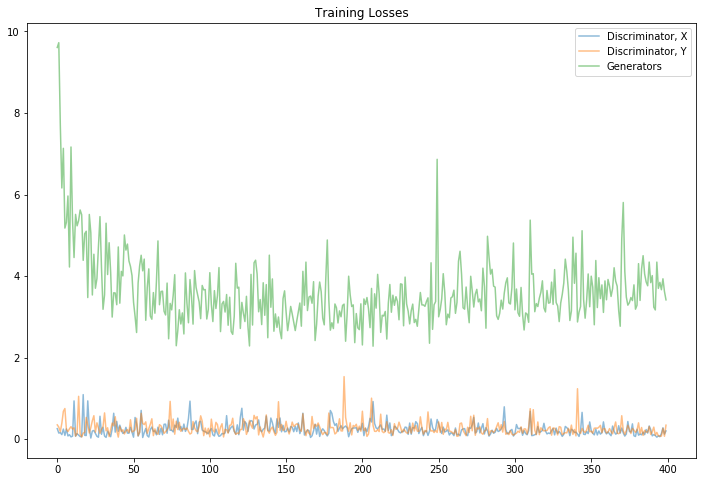

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='notebook_images/sample-004000-summer2winter.png' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [35]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


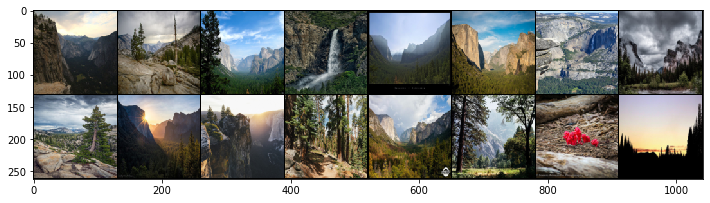

In [36]:
# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

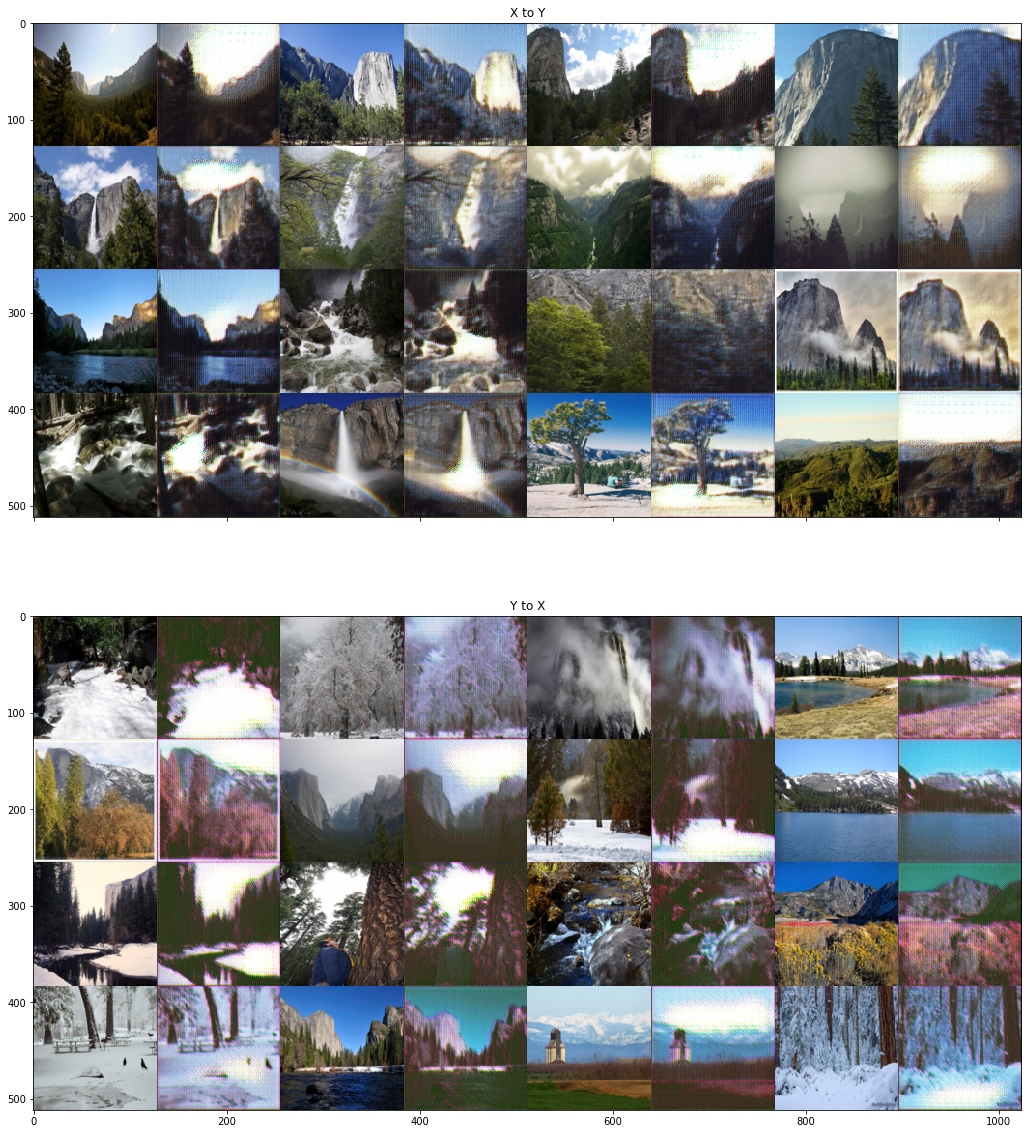

In [37]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

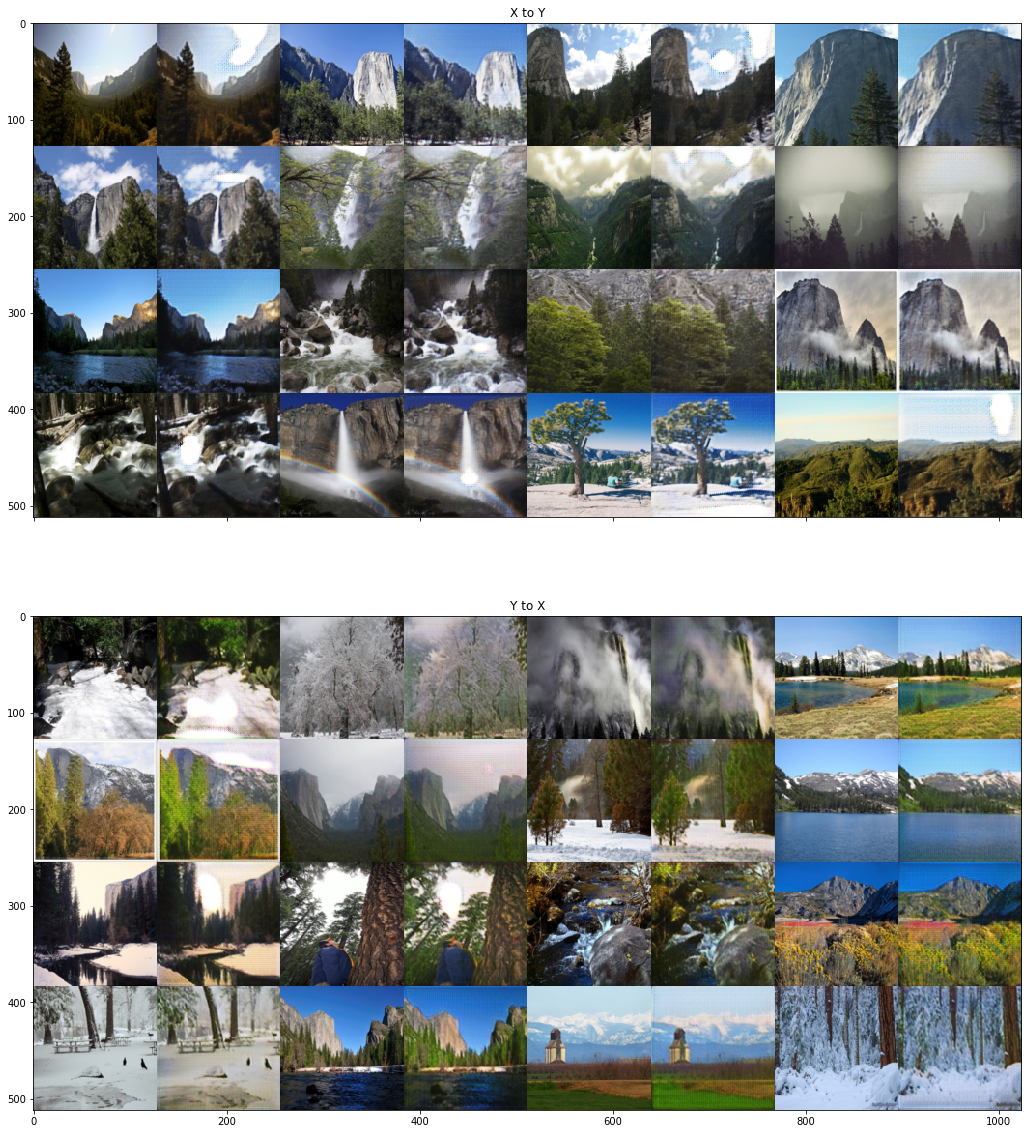

In [38]:
# view samples at iteration 1000
view_samples(1000, 'samples_cyclegan')

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.